In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("C:\\Users\\ishaa\\Desktop\\Hackathon\\hmnist_28_28_RGB.csv")
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
print(df["label"].value_counts())

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64


In [4]:
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["label"])
y = df["label"]

# Apply SMOTE on the original multi-class labels
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print class distribution BEFORE binary conversion
print("Class distribution after SMOTE (before binary conversion):")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE (before binary conversion):
label
2    6705
4    6705
3    6705
6    6705
5    6705
1    6705
0    6705
Name: count, dtype: int64


In [5]:
# Convert multi-class labels to binary (Cancer = 1, Non-Cancer = 0)
cancer_classes = {0, 1, 6}  # Define cancer-related classes
y_resampled_binary = y_resampled.apply(lambda label: 1 if label in cancer_classes else 0)

# Print class distribution AFTER binary conversion
print("\nClass distribution after binary conversion:")
print(pd.Series(y_resampled_binary).value_counts())

# Create balanced dataset
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=df.columns[:-1]), 
                         pd.DataFrame(y_resampled_binary, columns=["label"])], axis=1)


Class distribution after binary conversion:
label
0    26820
1    20115
Name: count, dtype: int64


In [6]:
df_balanced.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,0
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,0
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,0
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,0
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,0


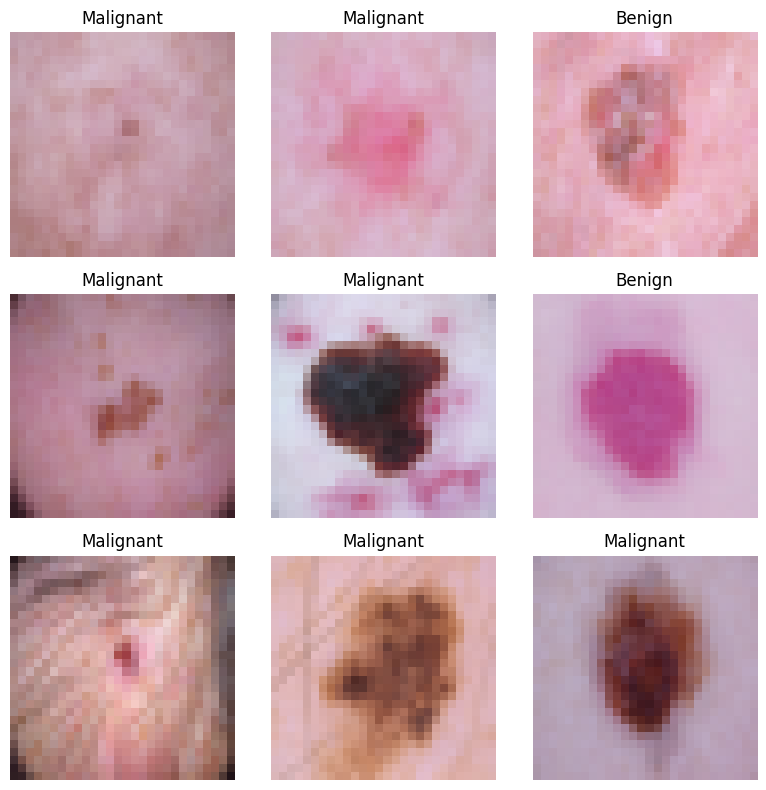

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define binary class labels
classes = {0: "Benign", 1: "Malignant"}

# Extract pixel values (ignore the label column)
X = df_balanced.iloc[:, :-1].values  # Exclude the last column (label)

# Ensure correct reshaping
num_images = X.shape[0]
X = X.reshape(num_images, 28, 28, 3).astype(np.uint8)

# Extract labels
y = df_balanced.iloc[:, -1].values  # Get the last column (label)

# Select 9 random images
selected_indices = random.sample(range(num_images), 9)

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for ax, idx in zip(axes.flat, selected_indices):
    ax.imshow(X[idx])  # Display image
    ax.set_title(classes[y[idx]])  # Use class label as title
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split dataset into training & testing (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize pixel values (0 to 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# CNN Model
model = Sequential([
    # Conv Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(2, 2),

    # Conv Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification (0 = benign, 1 = malignant)
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Can increase for better accuracy
    batch_size=32
)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


C:\Users\ishaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5770 - loss: 0.6637 - val_accuracy: 0.6641 - val_loss: 0.5996
Epoch 2/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6570 - loss: 0.5797 - val_accuracy: 0.7057 - val_loss: 0.5325
Epoch 3/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7043 - loss: 0.5303 - val_accuracy: 0.7461 - val_loss: 0.4941
Epoch 4/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7390 - loss: 0.4974 - val_accuracy: 0.7742 - val_loss: 0.4633
Epoch 5/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7661 - loss: 0.4681 - val_accuracy: 0.7830 - val_loss: 0.4482
Epoch 6/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7776 - loss: 0.4519 - val_accuracy: 0.7965 - val_loss: 0.4292
Epoch 7/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7889 - loss: 0.4339 - val_accuracy: 0.8008 - val_loss: 0.4151
Epoch 8/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8032 - loss: 0.4133 - 

In [16]:
from tensorflow.keras.layers import MaxPool2D

model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7,activation='sigmoid'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 1, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │              

 Total params: 504,103 (1.92 MB)

 Trainable params: 502,983 (1.92 MB)

 Non-trainable params: 1,120 (4.38 KB)

In [17]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [18]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [22]:
Optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Optimizer, metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=128,
                    epochs=50,
                    shuffle=True)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5019 - loss: 1.5654 - val_accuracy: 0.4272 - val_loss: 2.1577
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8712 - loss: 0.3475 - val_accuracy: 0.8399 - val_loss: 0.3874
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9081 - loss: 0.2263 - val_accuracy: 0.8844 - val_loss: 0.3134
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9335 - loss: 0.1650 - val_accuracy: 0.9165 - val_loss: 0.2136
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9506 - loss: 0.1274 - val_accuracy: 0.9138 - val_loss: 0.2077
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9613 - loss: 0.1026 - val_accuracy: 0.7791 - val_loss: 0.8999
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9682 - loss: 0.0873 - val_accuracy: 0.7807 - val_loss: 1.0968
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9733 - loss: 0.0705 - val_accu

In [24]:
model.save("one.h5")

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# Conv Layer 1
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Layer 2
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Layer 3 (Optional, for deeper feature extraction)
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer for Binary Classification (1 neuron + Sigmoid activation)
model.add(Dense(1, activation='sigmoid'))  # 1 neuron for binary classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy',  # Use binary loss
              metrics=['accuracy'])

# Model summary
model.summary()

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,817 (979.75 KB)

 Trainable params: 249,985 (976.50 KB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6684 - loss: 0.6110 - val_accuracy: 0.7618 - val_loss: 0.4921
Epoch 2/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8288 - loss: 0.3616 - val_accuracy: 0.7907 - val_loss: 0.4121
Epoch 3/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8828 - loss: 0.2742 - val_accuracy: 0.7515 - val_loss: 0.5595
Epoch 4/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9121 - loss: 0.2145 - val_accuracy: 0.8128 - val_loss: 0.3938
Epoch 5/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9126 - loss: 0.2063 - val_accuracy: 0.8590 - val_loss: 0.3286
Epoch 6/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9370 - loss: 0.1572 - val_accuracy: 0.9361 - val_loss: 0.1531
Epoch 7/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9507 - loss: 0.1261 - val_accuracy: 0.8977 - val_loss: 0.2350
Epoch 8/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9573 - loss: 0.1146 - val_accuracy: 0

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the CNN model
model = Sequential()

# Conv Layer 1
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 3), 
                 padding='same', kernel_regularizer=l2(0.001)))  # L2 Regularization
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Layer 2
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Layer 3 (Deeper feature extraction)
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Increased dropout

# Output Layer for Binary Classification
model.add(Dense(1, activation='sigmoid'))  # 1 neuron for binary classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy',  
              metrics=['accuracy'])

# Callbacks: Early Stopping & Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, 
                    callbacks=[early_stop, lr_scheduler])


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,817 (979.75 KB)

 Trainable params: 249,985 (976.50 KB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6694 - loss: 1.0431 - val_accuracy: 0.6582 - val_loss: 0.9068 - learning_rate: 0.0010
Epoch 2/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8150 - loss: 0.6367 - val_accuracy: 0.8353 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 3/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8682 - loss: 0.4737 - val_accuracy: 0.8015 - val_loss: 0.5787 - learning_rate: 0.0010
Epoch 4/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8797 - loss: 0.4358 - val_accuracy: 0.6738 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 5/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8967 - loss: 0.4080 - val_accuracy: 0.8810 - val_loss: 0.4305 - learning_rate: 0.0010
Epoch 6/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9090 - loss: 0.3764 - val_accuracy: 0.8590 - val_loss: 0.4705 - learning_rate: 0.0010
Epoch 7/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9210 - loss: 0.3548 

In [28]:
model.save("final.h5")

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9764 - loss: 0.1804 
Test Loss: 0.1852
Test Accuracy: 0.9757
